### Orel Hagai 314831819
### David Turgeman 314735564

https://github.com/aaddii314/apartments_project

In [194]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [195]:
def extract_room_num_from_text(rooms):
    if rooms["room_num"]<1:
        
        match = re.search(r'(\d+(\.\d+)?)\s*חדר', rooms["description"])
        if match:
            return float(match.group(1))
        return None
    return rooms["room_num"]

In [302]:
# פונקציית עיבוד לסט האימון: מכינה את הדאטה ושומרת טבלאות עזר לשימוש בסט הבחינה

def prepare_train_data(data_frame):
    df = data_frame.copy()
    df.replace("nan", np.nan, inplace=True)
    df = df.dropna(subset=['price'])

    #  מכיוון ששמנו לב שבשתי השכונות האלו באופן גורף היה חסר מרחק מהמרכז הוספנו ידנית 
    df.loc[df['neighborhood'] == "כוכב הצפון", 'distance_from_center'] = 3.4
    df.loc[df['neighborhood'] == "גני צהלה", 'distance_from_center'] = 9.0

    # חישוב חציוני מרחק לכל שכונה
    distance_by_neighborhood = df[df['distance_from_center'] > 0].groupby('neighborhood')['distance_from_center'].median()
    df.loc[df['distance_from_center'] == 0, 'distance_from_center'] = df['neighborhood'].map(distance_by_neighborhood)
    df['distance_from_center'] = df.groupby('neighborhood')['distance_from_center'].transform(lambda x: x.fillna(x.mean()))

    # סינון סוגי נכסים לא רלוונטיים
    invalid_types = ["סטודיו/לופט","החלפת דירות", "מחסן", "חניה","באתר מופיע ערך שלא ברשימה הסגורה", "סאבלט"]
    df = df[~df['property_type'].isin(invalid_types)]
    df = df[(df['area'] >= 15) & (df['area'] < 300)]


    # עיבוד עמודת קומה
    df['floor'] = df['floor'].astype(str)
    df.loc[df['floor'].str.contains('קרקע', case=False, na=False), 'floor'] = "0"
    # טיפול במקרים שבהם כתוב לדוג' 1מתוך 6
    df['floor'] = df['floor'].str.split().str[0]
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

    # חציון קומה לשכונה-ההיגיון הוא שלשכונה יש אופי מבחינת גובה הבנייה
    valid_floor_mask = (df['floor'] >= -3) & (df['floor'] <= 60)
    median_floor_by_neighborhood = df[valid_floor_mask].groupby('neighborhood')['floor'].median().round()
    df = df.merge(median_floor_by_neighborhood.rename('med_floor'), on='neighborhood', how='left')
    invalid_mask = df['floor'].isna() | (df['floor'] < -2) | (df['floor'] > 60)
    df.loc[invalid_mask, 'floor'] = df.loc[invalid_mask, 'med_floor']
    df.drop(columns=['med_floor'], inplace=True)

    # השלמה של room_num מטקסט
    df['room_num'] = df.apply(extract_room_num_from_text, axis=1)
    df = df[df['room_num'].notna()]
    df['garden_area'] = df['garden_area'].fillna(0)

    # מילוי חציון קומות
    median_floor = df['floor'].median()
    median_total_floors = df['total_floors'].median()
    df['floor'] = df['floor'].fillna(median_floor)
    df['total_floors'] = df['total_floors'].fillna(median_total_floors)
    df.loc[df['floor'] > df['total_floors'], 'floor'] = df['total_floors']

    df['num_of_payments'] = df['num_of_payments'].fillna(12)

    # חציון ועד בית לפי טווח שטח- ההיגיון הוא שועד בית היא לפי גודל דירה
    bin_size = 20
    df['area_bin'] = (df['area'] // bin_size) * bin_size
    building_tax_by_area_bin = df.groupby('area_bin')['building_tax'].median()

    def fill_building_tax(row):
        if pd.notnull(row['building_tax']):
            return row['building_tax']
        return building_tax_by_area_bin.get(row['area_bin'], df['building_tax'].median())

    df['building_tax'] = df.apply(fill_building_tax, axis=1)
    df['building_tax'] = df['building_tax'].fillna(df['building_tax'].median())
    df.drop(columns='area_bin', inplace=True)

    # ארנונה- ההיגיון דומה לועד בית ((חסר לנו מידע על מנת לחשב במדויק)
    df['monthly_arnona'] = df['monthly_arnona'].replace(0.0, np.nan)
    bins = [0, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, np.inf]
    labels = ['0-40', '40-60', '60-80', '80-100', '100-120', '120-140', '140-160',
              '160-180', '180-200', '200-250', '250-300', '300+']
    df['area_group'] = pd.cut(df['area'], bins=bins, labels=labels, include_lowest=True)
    arnona_by_area_group = df.groupby('area_group', observed=False)['monthly_arnona'].median()

    def fill_arnona_by_area(row):
        if pd.isna(row['monthly_arnona']):
            return arnona_by_area_group.get(row['area_group'], df['monthly_arnona'].median())
        return row['monthly_arnona']

    df['monthly_arnona'] = df.apply(fill_arnona_by_area, axis=1)

    # הורדת כפילויות
    columns_to_check = ['room_num', 'floor', 'area', 'neighborhood', 'price', 'address',
                        'monthly_arnona', 'property_type', 'building_tax']
    df = df.drop_duplicates(subset=columns_to_check, keep='first')

    # שינוי יחידות למטרים (היתה בעיה שחלק היה כתוב בק"מ)
    df.loc[df['distance_from_center'] < 20, 'distance_from_center'] *= 1000

    # הורדת עמודות לא רלוונטיות
    cols_to_drop = ['num_of_images', 'description', 'days_to_enter', 'address',
                    'num_of_payments', 'area_group']
    df.drop(columns=cols_to_drop, inplace=True)

    # סינון לפי שכ"ד למ"ר
    df['price_per_sqm'] = df['price'] / df['area']
    df = df[(df['price_per_sqm'] >= 30) & (df['price_per_sqm'] <= 300)]
    df.drop(columns='price_per_sqm', inplace=True)

    #שמירת כל המשתנים הרלוונטים בטבלה גם לטסט מתוך הנחה שבטסט אי אפשר לעשות מניפולציות כי יכולה להיות גם דירה אחת בלבד
    reference_tables = {
        'distance_by_neighborhood': distance_by_neighborhood,
        'median_floor_by_neighborhood': median_floor_by_neighborhood,
        'building_tax_by_area_bin': building_tax_by_area_bin,
        'arnona_by_area_group': arnona_by_area_group,
        'median_total_floors': median_total_floors,
        'median_floor': median_floor
    }

    return df, reference_tables

In [304]:
def prepare_test_data(data_frame_test, reference_tables):
    df = data_frame_test.copy()
    df.replace("nan", np.nan, inplace=True)

    df.loc[df['neighborhood'] == "כוכב הצפון", 'distance_from_center'] = 3.4
    df.loc[df['neighborhood'] == "גני צהלה", 'distance_from_center'] = 9.0
    df.loc[df['distance_from_center'] == 0, 'distance_from_center'] = df['neighborhood'].map(reference_tables['distance_by_neighborhood'])
    df['distance_from_center'] = df.groupby('neighborhood')['distance_from_center'].transform(lambda x: x.fillna(x.mean()))

    df = df[~df['property_type'].isin(["החלפת דירות", "מחסן", "חניה","סטודיו/לופט" ,"באתר מופיע ערך שלא ברשימה הסגורה", "סאבלט"])]
    df = df[(df['area'] >= 15) & (df['area'] < 300)]


    df['floor'] = df['floor'].astype(str)
    df.loc[df['floor'].str.contains('קרקע', case=False, na=False), 'floor'] = "0"
    df['floor'] = df['floor'].str.split().str[0]
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
    df = df.merge(reference_tables['median_floor_by_neighborhood'].rename('med_floor'), on='neighborhood', how='left')
    invalid_mask = df['floor'].isna() | (df['floor'] < -2) | (df['floor'] > 60)
    df.loc[invalid_mask, 'floor'] = df.loc[invalid_mask, 'med_floor']
    df.drop(columns=['med_floor'], inplace=True)

    df['room_num'] = df.apply(extract_room_num_from_text, axis=1)
    df = df[df['room_num'].notna()]
    df['garden_area'] = df['garden_area'].fillna(0)

    df['floor'] = df['floor'].fillna(reference_tables['median_floor'])
    df['total_floors'] = df['total_floors'].fillna(reference_tables['median_total_floors'])
    df.loc[df['floor'] > df['total_floors'], 'floor'] = df['total_floors']

    df['num_of_payments'] = df['num_of_payments'].fillna(12)
    df['area_bin'] = (df['area'] // 20) * 20
    df['building_tax'] = df.apply(lambda row: row['building_tax'] if pd.notnull(row['building_tax']) else reference_tables['building_tax_by_area_bin'].get(row['area_bin'], np.nan), axis=1)
    df['building_tax'] = df['building_tax'].fillna(reference_tables['building_tax_by_area_bin'].median())
    df.drop(columns='area_bin', inplace=True)

    df['monthly_arnona'] = df['monthly_arnona'].replace(0.0, np.nan)
    bins = [0, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, np.inf]
    labels = ['0-40', '40-60', '60-80', '80-100', '100-120', '120-140', '140-160',
              '160-180', '180-200', '200-250', '250-300', '300+']
    df['area_group'] = pd.cut(df['area'], bins=bins, labels=labels, include_lowest=True)
    df['monthly_arnona'] = df.apply(lambda row: row['monthly_arnona'] if pd.notna(row['monthly_arnona']) else reference_tables['arnona_by_area_group'].get(row['area_group'], np.nan), axis=1)
    df['monthly_arnona'] = df['monthly_arnona'].fillna(df['monthly_arnona'].median())

    df.loc[df['distance_from_center'] < 20, 'distance_from_center'] *= 1000

    df.drop(columns=['num_of_images', 'description', 'days_to_enter', 'address', 'num_of_payments', 'area_group'], inplace=True)

    df['price_per_sqm'] = df['price'] / df['area']
    df = df[(df['price_per_sqm'] >= 30) & (df['price_per_sqm'] <= 300)]
    df.drop(columns='price_per_sqm', inplace=True)

    return df


### write the function if it's train or test

In [307]:
#סיווג אם הדאטה היא טריין או טסט ולפי זה מפעילה את הפןנקציה הרלוונטית
def prepare_data(df, mode):
    if mode == 'train':
        return prepare_train_data(df)
    elif mode == 'test':
        return prepare_test_data(df)
    else:
        raise ValueError("Mode must be 'train' or 'test'")


In [309]:
df = pd.read_csv("C:/Users/User/Downloads/train.csv")

In [311]:
result=prepare_train_data(df)

In [314]:
result[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 0 to 748
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_type         684 non-null    object 
 1   neighborhood          684 non-null    object 
 2   room_num              684 non-null    float64
 3   floor                 684 non-null    float64
 4   area                  684 non-null    int64  
 5   garden_area           684 non-null    float64
 6   monthly_arnona        684 non-null    float64
 7   building_tax          684 non-null    float64
 8   total_floors          684 non-null    float64
 9   has_parking           684 non-null    int64  
 10  has_storage           684 non-null    int64  
 11  elevator              684 non-null    int64  
 12  ac                    684 non-null    int64  
 13  handicap              684 non-null    int64  
 14  has_bars              684 non-null    int64  
 15  has_safe_room         684 no

In [316]:
##### from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# פונקציה לחישוב Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# שלב א': משתני מטרה ומאפיינים
if isinstance(result, tuple):
    result = result[0]

X = result.drop(columns=['price'])
y = result['price']

# המרת עמודות קטגוריאליות ל-one-hot
X = pd.get_dummies(X, drop_first=True)

# הסרת שורות עם ערכים חסרים
X = X[X['room_num'].notna()]
y = y[X.index]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNetCV(cv=10, random_state=42))
])

pipeline.fit(X, y)

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=10,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
)

r2_mean = np.mean(cv_results['test_r2'])
mae_mean = -np.mean(cv_results['test_neg_mean_absolute_error'])
rmse_mean = -np.mean(cv_results['test_neg_root_mean_squared_error'])
adj_r2 = adjusted_r2(r2_mean, X.shape[0], X.shape[1])

# הצגת מדדים
print("R² ממוצע:", r2_mean)
print("Adjusted R²:", adj_r2)
print("MAE ממוצע:", mae_mean)
print("RMSE ממוצע:", rmse_mean)

R² ממוצע: 0.4141853185222534
Adjusted R²: 0.32299250854602213
MAE ממוצע: 2213.0191433279324
RMSE ממוצע: 3189.0441331695583


In [318]:
# שליפת מודל מאומן מה-pipeline
model = pipeline.named_steps['elastic']

# הפקת המקדמים
coefs = pd.Series(model.coef_, index=X.columns)

# הצגת 5 החשובים ביותר
top5 = coefs.abs().sort_values(ascending=False).head(5)
print("5 הפיצ'רים המשפיעים ביותר:\n", top5)


5 הפיצ'רים המשפיעים ביותר:
 area              516.008789
room_num          306.964083
monthly_arnona    209.701555
has_parking       203.728639
handicap          196.838918
dtype: float64


In [320]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# משתני מטרה ותכונות
X = result.drop(columns=['price'])
y = result['price']

# עמודות קטגוריאליות
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# טרנספורמציה לקטגוריות
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# פייפליין
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeRegressor(random_state=0))
])

In [322]:
param_grid = {
    'model__max_depth': [3, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X, y)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['property_type',
                                                                          'neighborhood'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_absolute_error')

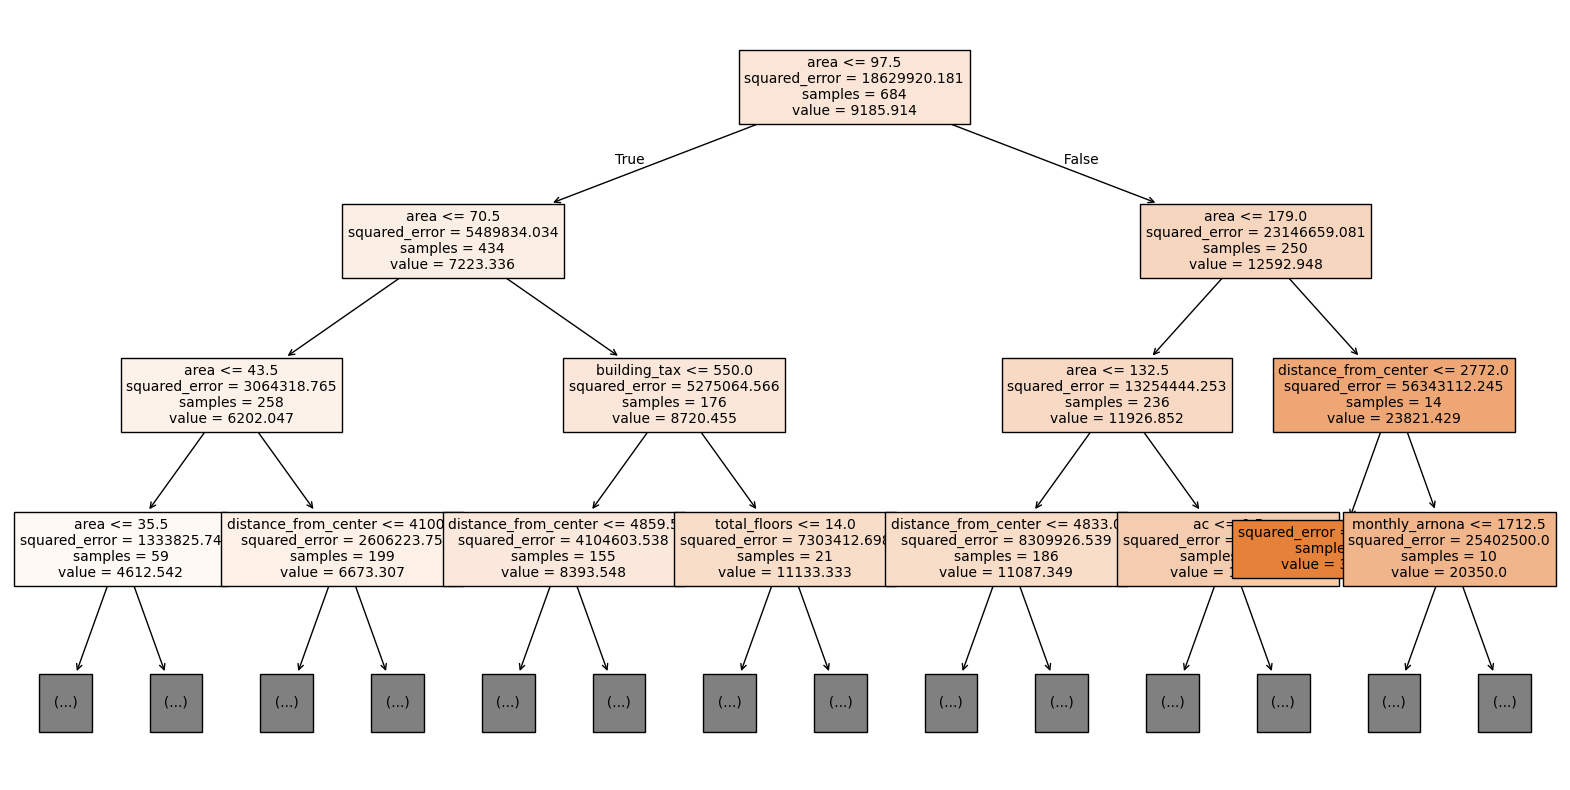

In [323]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# שלב 1: שליפת המודל הכי טוב מתוך הפייפליין
best_tree = grid.best_estimator_.named_steps['model']

# שלב 2: הגדרת שמות הפיצ'רים
ohe = grid.best_estimator_.named_steps['preprocess'].named_transformers_['cat']
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()
feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols

# שלב 3: ציור העץ
plt.figure(figsize=(20, 10))
plot_tree(best_tree, 
          filled=True,
          feature_names=feature_names,
          max_depth=3,  # להוריד עומק אם צריך
          fontsize=10)
plt.show()


In [324]:
# שחזור שמות הפיצ'רים לאחר OneHot
ohe = grid.best_estimator_.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = list(ohe_features) + num_cols

# חשיבות
importances = grid.best_estimator_.named_steps['model'].feature_importances_
top5 = sorted(zip(all_features, importances), key=lambda x: x[1], reverse=True)[:5]
for name, val in top5:
    print(f"{name}: {val:.4f}")


area: 0.8188
distance_from_center: 0.0992
ac: 0.0206
monthly_arnona: 0.0144
building_tax: 0.0143


In [325]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred = grid.predict(X)
print("MAE:", mean_absolute_error(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))
print("R²:", r2_score(y, y_pred))

MAE: 1470.8433465052494
MSE: 4394400.05530376
R²: 0.7641213696799078


In [326]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import pandas as pd
import numpy as np

# אם result הוא טאפלים
if isinstance(result, tuple):
    result = result[0]

# משתני מטרה ותכונות
X = result.drop(columns=['price'])
y = result['price']

# עמודות קטגוריאליות ומספריות
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# טרנספורמציה לקטגוריות
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# בניית pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeRegressor(random_state=0))
])

# גריד לחיפוש פרמטרים
param_grid = {
    'model__max_depth': [3, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Grid Search עם cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X, y)

# שחזור שמות הפיצ’רים לאחר OneHotEncoding
ohe = grid.best_estimator_.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = list(ohe_features) + num_cols

# חשיבות פיצ'רים
importances = grid.best_estimator_.named_steps['model'].feature_importances_
top5 = sorted(zip(all_features, importances), key=lambda x: x[1], reverse=True)[:5]

print("חמשת הפיצ'רים המשפיעים ביותר:")
for name, val in top5:
    print(f"{name}: {val:.4f}")



חמשת הפיצ'רים המשפיעים ביותר:
area: 0.8188
distance_from_center: 0.0992
ac: 0.0206
monthly_arnona: 0.0144
building_tax: 0.0143


In [327]:
# חיזוי על כל הסט
y_pred = grid.predict(X)

# מטריקות
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

# מספר הפיצ'רים בפועל לאחר טרנספורמציה
X_transformed = grid.best_estimator_.named_steps['preprocess'].transform(X)
p_actual = X_transformed.shape[1]
n = X_transformed.shape[0]

# Adjusted R²
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p_actual - 1)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)


MAE: 1470.8433465052494
MSE: 4394400.05530376
R²: 0.7641213696799078
Adjusted R²: 0.7264769023622701


### השוואת ביצועי המודלים

| מדד                  | ElasticNet         | Decision Tree        | מודל מועדף      |
|----------------------|--------------------|----------------------|------------------|
| R²                   | 0.3546             | 0.7420               | עץ החלטה        |
| Adjusted R²          | 0.2532             | 0.7004               | עץ החלטה        |
| MAE                  | 2,478.54 ₪         | 1,662.99 ₪           | עץ החלטה        |
| RMSE                 | 4,243.45 ₪         | ≈ 2,854.42 ₪         | עץ החלטה        |

#### מתאם=R^2
#### המתאם במודל הראשון נמוך מאוד לכן קל לראות שמודל של עץ החלטה עדיף עם הנתונים שלנו.


## מסקנה:
מודל עץ החלטה הציג ביצועים משמעותית טובים יותר בכל המדדים: הוא מסביר אחוז גבוה יותר מהשונות , שגיאות ממוצעות נמוכות יותר , ולכן נבחר כמודל המועדף.


<div dir="rtl">

##  מודל 1 – ElasticNet

### 5 הפיצ'רים המשפיעים ביותר:

| פיצ'ר               | השפעה | הסבר |
|---------------------|--------|------|
| `area`              | גבוהה מאוד | שטח הנכס – ככל שהוא גדול יותר, המחיר גבוה יותר. |
| `room_num`          | גבוהה | מספר חדרים משפיע על ההתאמה למשפחות ולכן על המחיר. |
| `monthly_arnona`    | גבוהה | ארנונה גבוהה מרמזת על אזור יוקרתי או שטח גדול. |
| `building_tax`      | בינונית | דמי ועד בניין – מעידים על איכות המבנה והשירותים. |
| `is_furnished`      | בינונית | דירה מרוהטת לרוב מושכרת במחיר גבוה יותר. |

---

##  מודל 2 – עץ החלטה 

### 5 הפיצ'רים החשובים ביותר:

| פיצ'ר                  | השפעה | הסבר |
|------------------------|--------|------|
| `area`                 | גבוהה מאוד | הקריטריון המרכזי לפיצול בעץ. |
| `distance_from_center` | גבוהה | ככל שהנכס קרוב יותר למרכז, המחיר גבוה יותר. |
| `total_floors`         | בינונית | גובה הבניין – מצביע על גיל וסוג המבנה. |
| `ac`                   | נמוכה | נוחות נוספת שמשפיעה מעט על מחיר. |
| `building_tax`         | נמוכה | שוב – מעיד על איכות ותחזוקת הבניין. |

---

## השוואה בין המודלים:

- שני המודלים מסכימים ש־`area` הוא הפיצ'ר המשפיע ביותר.
- ElasticNet מתמקד בפיצ'רים ישירים ומספריים כמו מספר חדרים וריהוט.
- עץ ההחלטה שם דגש על מבנה הדירה ומיקומה .
- ElasticNet פחות מתאים אם יש אינטראקציות מורכבות בין משתנים, מה שעץ ההחלטה מזהה טוב יותר.

</div>


In [215]:
import pandas as pd
import numpy as np

# Read the test CSV
test_df = pd.read_csv('test.csv')

# Assume the last column is the target
features = test_df.iloc[:, :-1]
res = test_df.iloc[:, -1]

# Prepare the features dataframe
features_prepared = prepare_data(features, "test")

# Make predictions
preds = en_model.predict(features_prepared)

# Compare RMSE between res and the predictions
rmse = np.sqrt(np.mean((res - preds) ** 2))
print("RMSE for ID", id, "is", rmse)


FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'